In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *

# Image Classification of Pets

This notebook will create a classifier for identifying pet breeds using fastai. It will also explore several of the techniques and approaches for fine tuning a model.

First, connecting to the PETS dataset that was previously downloaded.

In [3]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

Then, trying to understand the structure of the dataset.

path.ls() gives information about the contents of a directory.

In [4]:
Path.BASE_PATH = path

In [5]:
path.ls()

(#2) [Path('images'),Path('annotations')]

The line above shows that there are two folders in the base path location - images and annotations.
 The [website](https://www.robots.ox.ac.uk/~vgg/data/pets/) says that annotations gives information about the location of the pets - but we're interested in classifying their species, not their location. 
 
 Instead, looking inside the images folder:

In [6]:
(path/"images").ls()

(#7393) [Path('images/american_bulldog_56.jpg'),Path('images/Siamese_61.jpg'),Path('images/english_cocker_spaniel_66.jpg'),Path('images/shiba_inu_55.jpg'),Path('images/scottish_terrier_68.jpg'),Path('images/Abyssinian_153.jpg'),Path('images/Ragdoll_57.jpg'),Path('images/pug_182.jpg'),Path('images/Siamese_182.jpg'),Path('images/newfoundland_100.jpg')...]

Each filename contains the pet breed, an underscore, a number, and the file extension. The following lines extract the required information. 

In [7]:
fname = (path/"images").ls()[0]

In [8]:
re.findall(r'(.+)_\d+.jpg$', fname.name)

['american_bulldog']

I will apply this regex to the entire dataset. Fastai has a RegexLabeller class, that helps with labelling. I also use Fastai's datablock.

In [9]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
#                  telling the DataBlock that the data is image based
                 get_items=get_image_files, 
#                  set random seed
                 splitter=RandomSplitter(seed=42),
#                  use regex to extract y values from names
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
#                  resize and transfom as part of presizing
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))

# pointing the DataBlock to the images directory
dls = pets.dataloaders(path/"images")

## Presizing

Presizing is image preprocessing that does several things: give images same dimensions, so they can be transformed to tensors for GPU-based operations. Keeping image sizes consistent reduces the amount of distinct augmentation computations that are 
required, and makes for more efficient processing

Many common data augmentation transforms introduce spurious empty patches or degrade data. For example, simple rotation will introduce empty pixels into the image. Other techniques may interpolate pixels.

The solution works in two steps:
 1. Resize to a fairly large size, so all images are consistent.
 2. Combine the individual augmentations into one and perform the combined operation on the GPU once, instead of performing operations individually.

The resize creates images large enough to leave margins for further augmentation.

The GPU is used for all data augmentation, and all operations are done together, with a single interpolation at the end.

An example below from fastai's book showing the two steps in action.

<img alt="Presizing on the training set" width="600" caption="Presizing on the training set" id="presizing" src="images/att_00060.png">

A comparison of fastai's interpolation on the left with traditional approaches on the right

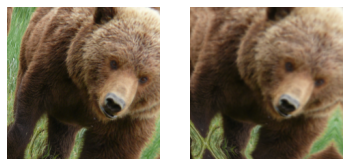

In [10]:
dblock1 = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_y=parent_label,
                   item_tfms=Resize(460))
# Place an image in the 'images/grizzly.jpg' subfolder where this notebook is located before running this
dls1 = dblock1.dataloaders([(Path.cwd()/'images'/'grizzly.jpg')]*100, bs=8)
dls1.train.get_idxs = lambda: Inf.ones
x,y = dls1.valid.one_batch()
_,axs = subplots(1, 2)

x1 = TensorImage(x.clone())
x1 = x1.affine_coord(sz=224)
x1 = x1.rotate(draw=30, p=1.)
x1 = x1.zoom(draw=1.2, p=1.)
x1 = x1.warp(draw_x=-0.2, draw_y=0.2, p=1.)

tfms = setup_aug_tfms([Rotate(draw=30, p=1, size=224), Zoom(draw=1.2, p=1., size=224),
                       Warp(draw_x=-0.2, draw_y=0.2, p=1., size=224)])
x = Pipeline(tfms)(x)
#x.affine_coord(coord_tfm=coord_tfm, sz=size, mode=mode, pad_mode=pad_mode)
TensorImage(x[0]).show(ctx=axs[0])
TensorImage(x1[0]).show(ctx=axs[1]);

### Checking and Debugging a DataBlock

The show_batch method allows for checking and debugging a datablock before its use.

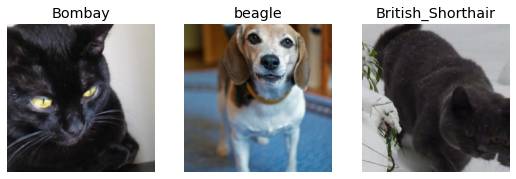

In [11]:
dls.show_batch(nrows=1, ncols=3)

The summary method will also help with debugging. it creates a batch from the source it is given, and provides a lot of details including points of failure.

In this case the resize option is missing, so the images are difference sizes and can't be used.

In [12]:
#hide_output
pets1 = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'))
pets1.summary(path/"images")

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/pug_130.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=300x225
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/pug_130.jpg
    applying partial gives
      pug
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(29)

Final sample: (PILImage mode=RGB size=300x225, TensorCategory(29))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item: Pipeline: ToTenso

RuntimeError: stack expects each tensor to be equal size, but got [3, 225, 300] at entry 0 and [3, 500, 434] at entry 1

You can see exactly how we gathered the data and split it, how we went from a filename to a *sample* (the tuple (image, category)), then what item transforms were applied and how it failed to collate those samples in a batch (because of the different shapes). 

Fastai often recommends training to a simple model initially, rather than overengineering an elaborate model from the start. This helps establish a baseline and gives an idea of the data can train a model at all.

Below, applying the loaded data to a neural net, with error rate used as the metric, and resnet34 used for transfer learning.

In [13]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.495750,0.379546,0.110284,00:41


epoch,train_loss,valid_loss,error_rate,time
0,0.519092,0.318868,0.104195,00:51
1,0.328350,0.243908,0.081867,00:51


That *loss* is the function chosen to optimize the parameters of the model. Fastai tries to select an appropriate loss function based on what kind of data and model being used. In this case, with image data and a categorical outcome,  fastai defaults to using *cross-entropy loss*.

*Cross-entropy loss* is a loss function works efficiently with multiple categories. I have already written a blog post on it, here:
https://frankiecoughlan.data.blog/2021/12/10/cross-entropy-loss/

## Model Interpretation

A confusion matrix will help see where the model is doing well, and where it's doing badly:

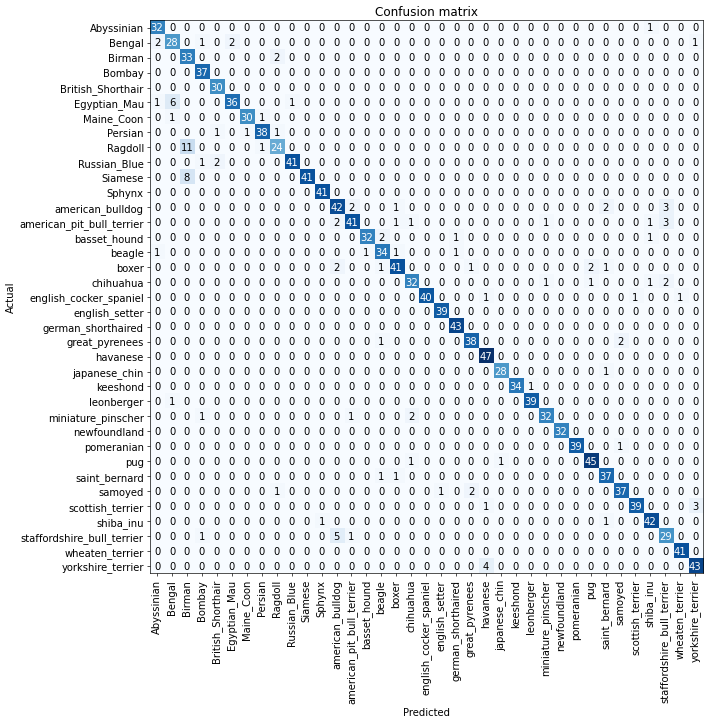

In [14]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

That confusion matrix is a little awkward to read. The most_confused method will show the cells of the confusion matrix with the most incorrect predictions.

In [15]:
interp.most_confused(min_val=5)

[('Ragdoll', 'Birman', 11),
 ('Siamese', 'Birman', 8),
 ('Egyptian_Mau', 'Bengal', 6),
 ('staffordshire_bull_terrier', 'american_bulldog', 5)]

Taking this as the baseline, the next section focuses on further improvements.

## Improving The Model

### The Learning Rate Finder

Finding the right learning rate is important:
Too low and it will take a long time to train. This wastes time, but can also cause overfitting.
Too high and it will overstep, overshooting the minimum loss. Repeating that can move the model away from the optimum solution, not closer.

This happens below with a learning rate of 10%

In [16]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr=0.1)

epoch,train_loss,valid_loss,error_rate,time
0,2.595832,4.773493,0.462788,00:42


epoch,train_loss,valid_loss,error_rate,time
0,3.344536,1.759175,0.500677,00:52


One approach to find the optimum learning rate (from Leslie Smith in 2015) is called the *learning rate finder*. Start with a tiny learning rate, use it for one mini-batch, and measure the loss. Double the rate, use it for one mini-batch, and measure the loss again. The loss will improve because we've taken a slightly bigger step in the right direction. Repeat until the loss gets worse. At that point, the learning rate is too large. It's common to select a learning rate slightly lower than that which produced the worsening loss. Two recommendations for choosing that point are (a) one order of magnitude lower that that where the minimum loss was achieved, or (b) the last point where the loss was clearly decreasing. (a) and (b) are often very similar.

The default learning rate for fastai is 1e-3.

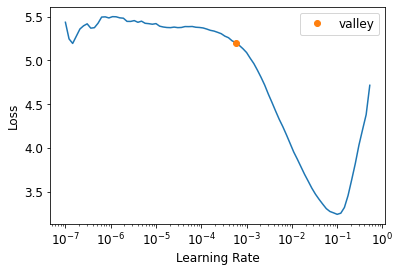

In [17]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
lr_steep = learn.lr_find()

In [18]:
# print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")
# print(f"steepest point: {lr_steep:.2e}")
lr_steep

SuggestedLRs(valley=0.0005754399462603033)

In the graph above, learning rates lower than 1e-4 won't allow the model to train - the slope is *flat*.
Rates higher than 1e-1 will cause the model to diverge - *positive* slope.
The point that produces the minimum loss is tempting, but the slope is flat here too.
The sweet spot is the point in the graph with the steepest negative slope.

In [19]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.338083,0.335476,0.114344,00:42


epoch,train_loss,valid_loss,error_rate,time
0,0.515815,0.395559,0.121110,00:52
1,0.328197,0.246691,0.081191,00:52


Now that we have a good learning rate to train our model, let's look at how we can fine-tune the weights of a pretrained model.

### Unfreezing and Transfer Learning

Transfer learning in a nutshell:

We take a pretrained model that is finetuned for a particular task. It has linear layers, with a nonlinear activation function between each linear pair, and an activation function like softmax at the end. The final linear layer uses a matrix with enough columns that the output size = number of classes in the classification problem.

This final linear won't help when we are transfer learning, because it is specifically designed to classify the categories in the original context. So when transfer learning that layer is discarded and replaced with a layer that provides the correct number of outputs for the new problem.
This new linear layer is random, but the output of the entire model isn't random because this final random layer sits on top of all the prior carefully trained layers.

The aim is to retain all the useful things learned in early layers and then apply them to our new problem. The trick is to freeze the weights for the prior layers, and tell the optimizer to only update the weights in the later randomly added layers.

Fastai automatically freezes pretrained layers when creating a model from a pretrained network.
The fine_tune method makes fastai do two things:

    Train the randomly added layers for one epoch, with all other layers frozen
    Unfreeze all the layers, and train them for all the epochs required
    
The method has parameters that can change its behaviour, or we can call the underlying methods directly to get custom behaviour. fit_one_cycle is fastai's method for training without fine_tune.

In [20]:
learn.fine_tune??

In [21]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.116380,0.320232,0.100135,00:42
1,0.500215,0.232039,0.082544,00:42
2,0.311268,0.217593,0.071042,00:42


Then we'll unfreeze the model:

In [22]:
learn.unfreeze()

and run `lr_find` again, because having more layers to train, and weights that have already been trained for three epochs, means our previously found learning rate isn't appropriate any more:

SuggestedLRs(valley=6.30957365501672e-05)

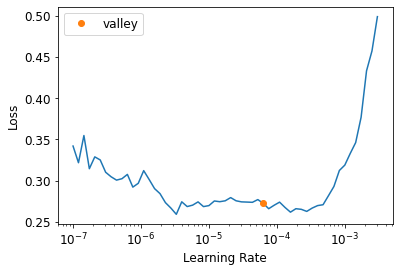

In [23]:
learn.lr_find()

The graph looks different this time - the flat line follwowed by the sharp increase is due to the fact that the model has been trained already. Looking for the point with maximum gradient won't help here, and instead it makes sense to choose a point well before the sharp increase, like 1e-5.

Training at that learning rate:

In [24]:
learn.fit_one_cycle(6, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.263528,0.210002,0.068336,00:52
1,0.244563,0.205126,0.065629,00:52
2,0.222098,0.198474,0.066982,00:52
3,0.208206,0.188793,0.064953,00:52
4,0.189803,0.188446,0.062923,00:52
5,0.171950,0.188208,0.060893,00:52


This improved the model a bit, but there's more that can be done. 

### Discriminative Learning Rates

After unfreezing, all of the weights can be changed by further training. However the quality or usefulness of the pretrained weights is higher than that of the randomly added parameters. The pretrained weights have been trained over a high number of epochs with a lot of data. The implication is that those pretrained weights would be better off with a lower learning rate, since less drastic change is required.

Also, earlier layers typically have learned generally useful things - like detecting edges and gradients - which is useful for any task. Later layers are far more specific, and so may be less relevant to the new task. It seems reasonable to let the later layers fine tune more quickly than the earlier ones.

Fastai's default approach is to use discriminative learning rates. It uses lower learning rates in the early layers and higher learning rate for the later layers.

In Fastai you can pass a first and last learning rate to the model (via a python slice object) and it will start training with the first rate, and finish with the last rate, making incremental steps in between.

See below for previous training reapplied with discriminative learning rates.

In [25]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.148262,0.386400,0.113667,00:41
1,0.512778,0.265714,0.081867,00:42
2,0.317848,0.220483,0.071719,00:42


epoch,train_loss,valid_loss,error_rate,time
0,0.259530,0.217136,0.068336,00:52
1,0.253279,0.214831,0.069012,00:52
2,0.231639,0.200939,0.068336,00:52
3,0.231327,0.196909,0.066306,00:52
4,0.194536,0.202778,0.064276,00:52
5,0.188108,0.207497,0.064276,00:52
6,0.163484,0.196749,0.064276,00:52
7,0.152131,0.195147,0.063599,00:52
8,0.137508,0.197857,0.061570,00:52
9,0.124463,0.194113,0.062923,00:52


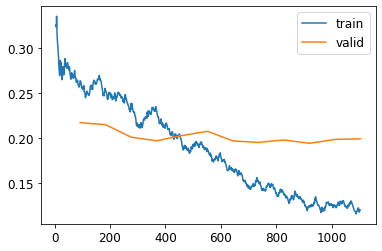

In [26]:
learn.recorder.plot_loss()

The training loss inmproves throughout, but the validation loss slows and plateaus. This is indicating the model is starting to overfit, and becoming overconfident in its predictions.

That doesn't mean it's getting less accurate. Accuracy continues to improve even as validation loss gets worse. The end goal is optimising the chosen metrics, not necessarily the loss.

### Number of Epochs

If time is a limiting factor, then an initial approach could be to train for the number of epochs that you're willing to wait for. Then looking at the training/validation loss plots and the metrics will help. If they are still improving in the final epochs then it might be worth training for longer.

If the validation loss get worse towards the end of training, then the model is first getting overconfident, then incorrectly memorizing the data. The latter is the real issue. If the validation loss is deteriorating while the other metrics are improving, then the model can still be performing better.

It's tempting to run the model for 100 epochs, choose the epoch with the best metrics, and pick that model as the winner. However, this approach doesn't allow the model to use the smallest rates on the epochs with the best metrics, so the model can't really fine-tune around the correct area. A better approach is to retrain the model from scratch with the number of epochs adjusted based on where the results were previously good.


### Deeper Architectures

In general (but this is a big generalisation), more parameters will lead to more accurate results. Deeper models also use more memory, so deeper models should use smaller batch sizxes to avoid 'out of memory' issues on the GPU.
Training on deeper architectures can be sped up by using 'mixed-precision training', where floating points are reduced from 32 to 16 places where possible.

Trying a deeper architecture with mixed precision:

In [27]:
from fastai.callback.fp16 import *
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.225672,0.324803,0.101489,00:59
1,0.575386,0.285569,0.094723,00:59
2,0.434662,0.291951,0.092693,00:59


epoch,train_loss,valid_loss,error_rate,time
0,0.250131,0.236548,0.079838,05:00
1,0.305030,0.369256,0.108254,05:01
2,0.236896,0.278430,0.083897,05:01
3,0.157580,0.250237,0.077808,05:00
4,0.087765,0.192653,0.058863,05:00
5,0.061192,0.196467,0.059540,05:00


In this case the deeper model doesn't provide a massive improvement.